<a href="https://colab.research.google.com/github/danielwhitt/FATE/blob/main/oscar_parcels_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
!pip install podaac-data-subscriber
# replace login and password with earth datalogin and password
!touch /root/.netrc
# replace your_uid with your nasa earth data id and replace your_password with your nasa earth data password
#!echo "machine urs.earthdata.nasa.gov login  your_uid password your_password" >> /root/.netrc

!chmod 0600 /root/.netrc

In [117]:
# download the last 30 days of OSCAR near real time surface currents, global files 1/4 degree
# change the start and end dates to the last 30 days
!podaac-data-downloader -c OSCAR_L4_OC_NRT_V2.0 -d ./data --start-date 2024-03-15T00:00:00Z --end-date 2024-04-15T00:00:00Z -e .nc


[2024-04-16 23:52:53,276] {podaac_data_downloader.py:317} INFO - Found 30 total files to download
[2024-04-16 23:52:53,448] {podaac_data_downloader.py:350} INFO - 2024-04-16 23:52:53.448308 SKIPPED: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240413.nc
[2024-04-16 23:52:53,681] {podaac_data_downloader.py:350} INFO - 2024-04-16 23:52:53.681544 SKIPPED: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240412.nc
[2024-04-16 23:52:53,864] {podaac_data_downloader.py:350} INFO - 2024-04-16 23:52:53.864495 SKIPPED: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240411.nc
[2024-04-16 23:52:54,027] {podaac_data_downloader.py:350} INFO - 2024-04-16 23:52:54.027459 SKIPPED: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240410.nc
[2024-

In [118]:
# 2002 data for comparison with globcurrent option? This takes 8 minutes, so comment out for now.
#!podaac-data-downloader -c OSCAR_L4_OC_FINAL_V2.0 -d ./data --start-date 2002-01-01T00:00:00Z --end-date 2003-01-01T00:00:00Z -e .nc

In [119]:
# download noaa buoy trajectory data
import urllib
urllib.request.urlretrieve("https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/OSMC_RealTime.nc?platform_type%2Ctime%2Clatitude%2Clongitude%2Cplatform_code&platform_type=%22DRIFTING%20BUOYS%20(GENERIC)%22&time%3E=2024-03-15T00%3A00%3A00Z&latitude%3E=-15&latitude%3C=15&longitude%3E=-180&longitude%3C=-90&orderBy(%22platform_code%2Ctime%22)","/content/buoydatafile.nc")

('/content/buoydatafile.nc', <http.client.HTTPMessage at 0x78ee6ef0d0f0>)

In [120]:
!pip install parcels
!pip install cftime
!pip install cgen
!pip install trajan
!pip install zarr
!pip install pymbolic

import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)

import parcels as ps

In [121]:
ds=xr.open_mfdataset("/content/data/oscar_currents_nrt_202404*.nc",decode_times=False)
ds['time'] = xr.coding.times.decode_cf_datetime(ds['time'], calendar='gregorian',units='days since 1990-01-01')
#ds.to_netcdf(path="/content/data/oscar_currents_nrt_20240411_greg.nc")



In [122]:
ds

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 13)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2024-04-01 2024-04-02 ... 2024-04-13
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    v        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-04-01T00:00:00
    time_coverage_end:          2024-04-01T23:59:59
    date_created:               2024-04-16

In [123]:
variables = {
    "U": "u",
    "V": "v",
}
dimensions = {"time": "time", "lat": "lat", "lon": "lon"}


In [124]:

fieldset=FieldSet.from_xarray_dataset(ds.transpose("time", "latitude", "longitude"),variables,dimensions,allow_time_extrapolation=True)


In [125]:
dsbuoy=xr.open_mfdataset('/content/buoydatafile.nc')
dsbuoy


<xarray.Dataset>
Dimensions:        (row: 3977)
Dimensions without coordinates: row
Data variables:
    platform_type  (row) object dask.array<chunksize=(3977,), meta=np.ndarray>
    time           (row) datetime64[ns] dask.array<chunksize=(3977,), meta=np.ndarray>
    latitude       (row) float64 dask.array<chunksize=(3977,), meta=np.ndarray>
    longitude      (row) float64 dask.array<chunksize=(3977,), meta=np.ndarray>
    platform_code  (row) object dask.array<chunksize=(3977,), meta=np.ndarray>
Attributes: (12/29)
    cdm_altitude_proxy:        observation_depth
    cdm_data_type:             Point
    Conventions:               COARDS, CF-1.6, Unidata Dataset Discovery v1.0
    Easternmost_Easting:       -90.0002
    featureType:               Point
    geospatial_lat_max:        12.0508
    ...                        ...
    subsetVariables:           platform_type
    summary:                   OSMC flattened observations from GTS, providin...
    time_coverage_end:         2024-04-16T11:00:00Z
    time_coverage_start:       2024-03-15T00:00:00Z
    title:                     OSMC flattened observations from GTS
    Westernmost_Easting:       -179.9976

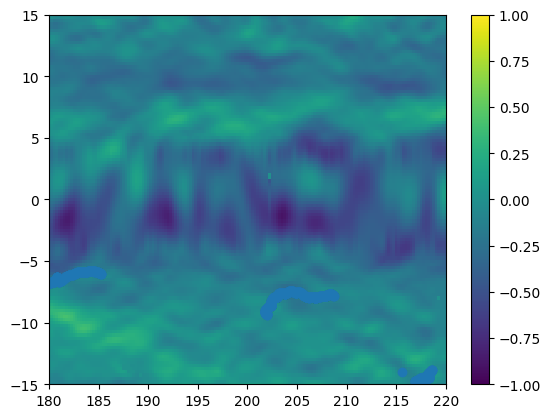

In [126]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[5, :, :])
#plt.xlabel("Zonal distance [m]")
#plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.clim(-1.0,1.0)

plt.scatter(360+dsbuoy.longitude,dsbuoy.latitude)

plt.xlim(180,220)
plt.ylim(-15,15)
plt.clim(-1.0,1.0)


plt.show()


In [134]:
pset2 = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=10,  # releasing 5 particles
    start=(206, -8),  # releasing on a line: the start longitude and latitude
    finish=(210, -8),  # releasing on a line: the end longitude and latitude
)
output_file = pset2.ParticleFile(
    name="OSCARparticlesOBS.zarr", outputdt=timedelta(hours=1)
)
pset2.execute(
    AdvectionRK4,
    runtime=timedelta(days=30),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticlesOBS.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticlesOBS.zarr.


100%|██████████| 2592000.0/2592000.0 [00:33<00:00, 78466.10it/s]


In [128]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=50,  # releasing 5 particles
    start=(197, 3),  # releasing on a line: the start longitude and latitude
    finish=(197, 9),  # releasing on a line: the end longitude and latitude
)


In [129]:
output_file = pset.ParticleFile(
    name="OSCARparticles163.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticles163.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticles163.zarr.


100%|██████████| 864000.0/864000.0 [00:07<00:00, 117541.15it/s]


In [130]:
pset1 = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=50,  # releasing 5 particles
    start=(199, 3),  # releasing on a line: the start longitude and latitude
    finish=(199, 9),  # releasing on a line: the end longitude and latitude
)
output_file = pset1.ParticleFile(
    name="OSCARparticles161.zarr", outputdt=timedelta(hours=1)
)
pset1.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticles161.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticles161.zarr.


100%|██████████| 864000.0/864000.0 [00:07<00:00, 114654.80it/s]


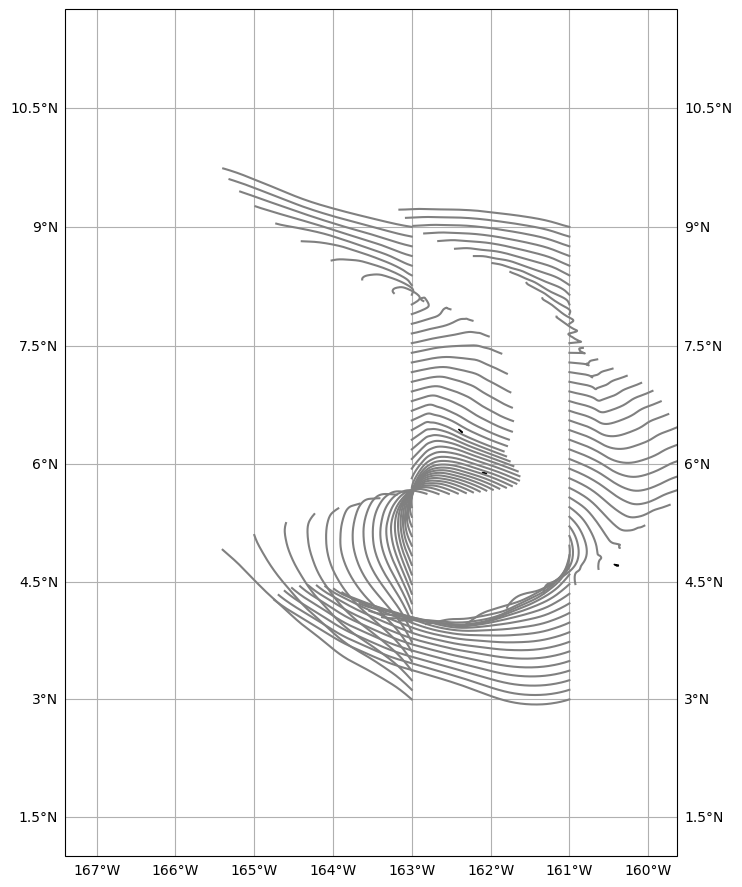

In [131]:
ds = xr.open_zarr("OSCARparticles163.zarr")
ds.traj.plot(margin=2)
ds1 = xr.open_zarr("OSCARparticles161.zarr")
ds1.traj.plot(margin=1)
plt.show()




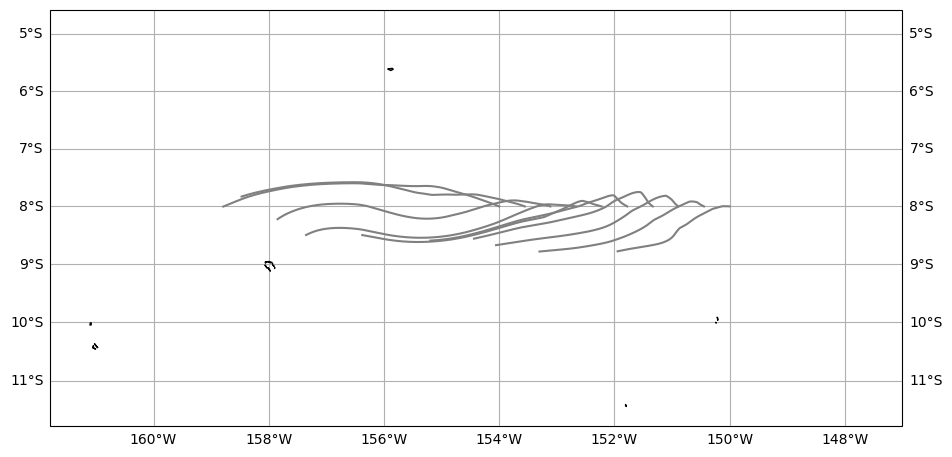

In [137]:
ds2 = xr.open_zarr("OSCARparticlesOBS.zarr")
ds2.traj.plot(margin=3)


plt.show()
# compare with the drifter track above (205 = 155 deg W)
# going in the right direction at least...

In [ ]:
%